## _Events from CSV_

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### _Load Dataset_

In [6]:
# mu+mu- data (current)
input_dir = 'train_all'

In [7]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [8]:
# event_id = 5
# hits, tubes, particles, truth = trackml.dataset.load_event(file_prefixes[event_id])

In [12]:
# hits.head()
# tubes.head()
# particles.head()
# truth.head()

### _SttCSVReader Class_

In [13]:
from src import SttCSVReader
from src import Draw_Reader_Event

In [14]:
reader = SttCSVReader(path=input_dir, noise=True, skewed=True)

### _1. Read Event_

In [15]:
event_id = 1074

In [16]:
data = reader(event_id)

In [17]:
# data.event_file

In [18]:
# data.hits.head()
# data.tubes.head()
# data.particles.head()
# data.event.head()

In [19]:
# data.event.layer.unique()

### _2. Event Display_

In [20]:
# Draw_Reader_Event(reader(event_id),figsize=(7,7),save_fig=False);

In [21]:
# Save Events for Inspection
# for e in range(8510, 8520):
#    Draw_Reader_Event(reader(e),figsize=(8,8),save_fig=True);

### _3. Reconstructable Events_

In [24]:
sum_tp, sum_rp = 0, 0

for i in range(len(file_prefixes[:100])):
    event = reader(i)
        
    truth_particles = event.particles.merge(event.truth, on='particle_id', how='left')
    sum_tp += np.unique(truth_particles.particle_id).size
    
    truth_particles = truth_particles[truth_particles.nhits > 5]                 # particles with nhits > 4
    reconstructable_particles = truth_particles[truth_particles.pt > 0.05]       # particles with pt > 50 MeV
    sum_rp += np.unique(reconstructable_particles.particle_id).size

In [25]:
print(f"Total True Tracks: {sum_tp}, Total Reconstructable Tracks: {sum_rp}")
print("Fraction of reconstructable particles (n > 4 and pt > 50MeV): {:.3f}".format((sum_rp/sum_tp)*100))

Total True Tracks: 437, Total Reconstructable Tracks: 330
Fraction of reconstructable particles (n > 4 and pt > 50MeV): 75.515


#### Histograms:

- Number of changed particles with pT > 50 MeV  per event
- Number of true tracks with pT > 50 MeV and leaving at least 5 spacepoints (hits) per event
- Number of spacepoints (hits) per event
- Check the hits criteria with the IdealTrackFinder algorithm, which is based on MC truth information.

### _4. Number of Hits/Track_

In [26]:
data = reader(8512)

In [27]:
data.particles

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,primary,pt,peta
0,7,-1.792720,0.727378,10.383900,-0.030073,-0.068671,0.146497,-1,28,-211,0.869761,1,0.074967,1.422943
1,6,-1.792720,0.727378,10.383900,-0.053826,0.102712,0.339467,1,11,2212,0.869761,1,0.115961,1.795240
2,5,0.633535,-0.257050,8.729440,0.015335,-0.101683,0.222657,1,24,211,0.405313,1,0.102833,1.515179
3,282,11.225600,19.993299,218.865005,0.099588,-0.075533,-0.500075,1,46,211,10.631400,0,0.124992,-2.094924


array([[<AxesSubplot:title={'center':'nhits'}>]], dtype=object)

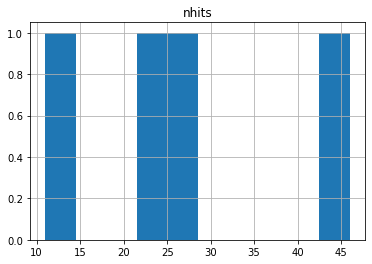

In [28]:
data.particles.hist(column='nhits')

### _5. Handling Noise Hits_

- from `LightningModule/Processing/utils/event_utils.py`

#### _1. Keep the Noise_

In [29]:
truth_1 = truth
hits_1 = hits

In [30]:
truth_1 = truth_1.merge(particles, on="particle_id", how="left") # how='left' keeps noise hits even if truth.particle_id is not matched with particles.particle_id

In [31]:
truth_1.particle_id.unique()

array([7, 8, 6, 5, 4])

In [32]:
hits_1 = hits_1.merge(truth_1, on="hit_id")

In [33]:
hits_1.particle_id.values

array([7, 7, 7, ..., 4, 4, 4])

In [34]:
# Here noise hits are assigned particle_id = 6, 46
hits_1.particle_id.unique()

array([7, 8, 6, 5, 4])

#### _2. Remove the Noise_

In [35]:
truth_2 = truth
hits_2 = hits

In [36]:
truth_2 = truth_2.merge(particles, on="particle_id", how="inner") # how='inner' removes noise hits, matched the truth.particle_id with particles.particle_id

In [37]:
truth_2.particle_id.unique()

array([7, 8, 6, 5, 4])

In [38]:
hits_2 = hits_2.merge(truth_2, on="hit_id", how="inner")

In [39]:
hits_2.particle_id.values

array([7, 7, 7, ..., 4, 4, 4])

In [40]:
hits_2.particle_id.unique()

array([7, 8, 6, 5, 4])

#### _3. Add/Remove Noise_

- from `src/event.py`

In [41]:
# particles (signal) info
particles.particle_id.values

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [42]:
# let see if noise hits are recorded
truth.particle_id.unique()

array([7, 8, 6, 5, 4])

In [43]:
h = hits.merge(truth, on='hit_id', how='left')

In [44]:
h.particle_id.unique()

array([7, 8, 6, 5, 4])

In [45]:
h = h.merge(particles, on='particle_id', how='left')

In [46]:
h.particle_id.unique()

array([7, 8, 6, 5, 4])

In [47]:
h.particle_id.values

array([7, 7, 7, ..., 4, 4, 4])